pointwise prediction where the input is injected in the last time step. input[num,seq_len]

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm

from scipy.io import loadmat
import matplotlib.pyplot as plt


from tqdm import tqdm

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf

# from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn

import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



2024-11-19 20:32:07.334668: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 20:32:07.383528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 20:32:08.687936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
num_time_steps=200

time_steps=torch.linspace(0,10,num_time_steps)

sin_wave=torch.sin(time_steps).reshape(-1, 1)




In [8]:
sequence_length=1

sequence_data = []
for i in range(num_time_steps - sequence_length):
    sequence_data.append(sin_wave[i: i + sequence_length+1, 0])


sequence_data=torch.stack(sequence_data)

num_train_samples=int(sequence_data.shape[0]*.8)



train_set = sequence_data[:num_train_samples, :]
test_set = sequence_data[num_train_samples:, :]



In [9]:
    # Take off the last element of each row and this will be our target value to predict.
x_train = train_set[:, :-1] #[batch,seq_len,1]
y_train = train_set[:, -1][:, np.newaxis].to(device)#[:, np.newaxis]
x_test = test_set[:, :-1]#[:, :, np.newaxis]
y_test = test_set[:, -1].to(device)#[:, np.newaxis]

x_train.shape

torch.Size([159, 1])

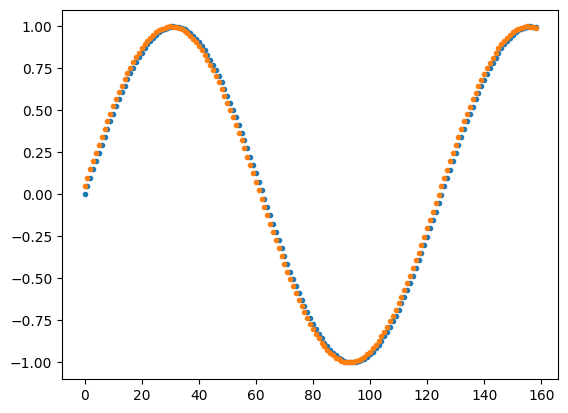

In [10]:
plt.plot(x_train.cpu().numpy(),'.')
plt.plot(y_train.cpu().numpy(),'.')

In [11]:
#parameters for the recurrent layer

dt = 0.001
T = 2.0
t=np.arange(0,T,dt)
N = 40                          #number of nodes in the cv-NN
epsilon = 50

phi = 1.5513                     #delay parameter
alpha = 1.0                      #power-law for the connectivity
f_mu = 5                          #(Hz) natural frequency
omega = (f_mu*np.ones((N,1)))*2*np.pi   #natural frequency

num=x_train.shape[0] # number of training samples 

def distance_dependent_graph(N, alpha):
    """
    Generates a distance-dependent graph based on a power-law for connectivity.

    Parameters:
    N (int): Number of nodes.
    alpha (float): Power-law exponent.

    Returns:
    numpy.ndarray: The adjacency matrix (weighted) representing the network.
    """
    # Initialize the adjacency matrix (A) and distance matrix (d)
    A = np.zeros((N, N))
    d = np.full((N, N), np.nan)

    # Calculate the distance between each pair of nodes considering periodic boundaries
    for ii in range(N):
        for jj in range(N):
            if ii == jj:
                continue  # Skip self-loops
            dist = abs(ii - jj)
            d[ii, jj] = min(dist, N - dist)  # Use periodic boundary conditions

    # Calculate the normalization factor eta
    eta = np.nansum(1.0 / d[0, :] ** alpha)

    # Calculate the adjacency matrix A using the power-law
    A = (1.0 / eta) * (1.0 / d ** alpha)

    # Ensure diagonal elements are zero (no self-loops)
    np.fill_diagonal(A, 0)

    return A


In [14]:
#Input

def cv_NN_input(x_train):
    input_data = np.zeros((x_train.shape[0],len(t)))
    gt = np.zeros((x_train.shape[0], x_train.shape[1]))  # Initialize gt array with zeros

    for i in range(x_train.shape[0]):

        # Flatten, normalize, and reshape the digit data
        #gt[i,:] = (digits[1, :, :]+noise*0).reshape(28 * 28)
        gt[i,:] = (x_train[i, :])


        #gt[i,:] /= np.max(gt[i, :])

            # Assign the processed data to the input vector
        for tt in range(len(t) - len(gt[i, :]), len(t)):
            input_data[i, tt] = gt[i, tt - (len(t) - len(gt[i, :]))]
            
    return input_data




In [16]:
input_data=cv_NN_input(x_train)

input_data=torch.tensor(input_data, dtype=torch.float32, requires_grad=False).to(device)


In [17]:
eps_in = 0.1
w_in = eps_in * np.random.rand(N, 1)
    
# Adjacency matrix (recurrent layer)
a = distance_dependent_graph(N, alpha)

K = epsilon * np.exp(-1j * phi) * a

# Initial condition
np.random.seed(100)
x_0 = np.random.rand(N) * np.exp(1j * 2 * np.pi * (np.random.rand(N) - 0.5))


#split the initial condition into real and imag part and convert it to torch tensor(not param as non trainable)

x_0_r=torch.tensor(x_0.real, dtype=torch.float32, requires_grad=False).to(device)

x_0_imag=torch.tensor(x_0.imag, dtype=torch.float32, requires_grad=False).to(device)

In [11]:
# class cv_NN(nn.Module):
#     def __init__(self, num, N, t, omega, dt, K, x_0_r, x_0_imag, device):
#         super(cv_NN, self).__init__()
        
        
#         # Store parameters
#         self.num = num
#         self.N = N
#         self.t = t
#         self.device = device
        
#         # Initialize real and imaginary parts of `x_th`
#         self.x_th_r = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device)
#         self.x_th_imag = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device)

        
        
#         # Compute `propagate` and split into real and imaginary parts
#         propagate = np.exp(1j * omega * dt) * expm(dt * K)
#         self.propagate_r = nn.Parameter(torch.tensor(propagate.real, dtype=torch.float32), requires_grad=False).to(device)
#         self.propagate_imag = nn.Parameter(torch.tensor(propagate.imag, dtype=torch.float32), requires_grad=False).to(device)

        
#         # Trainable parameter `W2`
#         self.W2 = nn.Parameter(torch.randn(N), requires_grad=True).to(device)
        
        
#         # Initialize the first state
#         self.x_th_r[:, 0, :] = x_0_r
#         self.x_th_imag[:, 0, :] = x_0_imag
        
        
#     def forward(self, inputD):
#         # Iterate over each sample in the batch and time steps
#         for i in range(self.num):
#             for j in range(1, len(self.t)):
#                 # Update the real and imaginary parts of the state
#                 self.x_th_r[i, j, :] = (
#                     torch.matmul(self.propagate_r, self.x_th_r[i, j - 1, :])
#                     - torch.matmul(self.propagate_imag, self.x_th_imag[i, j - 1, :])
#                     + self.W2 * inputD[i, j]
#                 )
                
#                 self.x_th_imag[i, j, :] = (
#                     torch.matmul(self.propagate_r, self.x_th_imag[i, j - 1, :])
#                     + torch.matmul(self.propagate_imag, self.x_th_r[i, j - 1, :])
#                 )
        
#         return self.x_th_r.to(self.device), self.x_th_imag.to(self.device)
        

In [18]:
class cv_NN(nn.Module):
    def __init__(self, num, N, t, omega, dt, K, x_0_r, x_0_imag, device):
        super(cv_NN, self).__init__()
        
        
        # Store parameters
        self.num = num
        self.N = N
        self.t = t
        self.device = device
        
        # Initialize real and imaginary parts of `x_th`
        self.x_th_r = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device)
        self.x_th_imag = torch.zeros((num, len(t), N), dtype=torch.float32, requires_grad=False).to(device)

        
        
        # Compute `propagate` and split into real and imaginary parts
        propagate = np.exp(1j * omega * dt) * expm(dt * K)
        self.propagate_r = nn.Parameter(torch.tensor(propagate.real, dtype=torch.float32), requires_grad=False).to(device)
        self.propagate_imag = nn.Parameter(torch.tensor(propagate.imag, dtype=torch.float32), requires_grad=False).to(device)

        
        # Trainable parameter `W2`
        self.W2 = nn.Parameter(torch.randn(N), requires_grad=True).to(device)
        
        
        # Initialize the first state
        self.x_th_r[:, 0, :] = x_0_r
        self.x_th_imag[:, 0, :] = x_0_imag
        
        
    def forward(self, inputD):
        
    # Expand propagate_r and propagate_imag to batch process with `torch.matmul`
        propagate_r_expanded = self.propagate_r.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)
        propagate_imag_expanded = self.propagate_imag.unsqueeze(0).expand(self.num, -1, -1)  # (num, N, N)

        # Iterate over time steps, starting from the second time step
        for j in range(1, inputD.shape[1]):
            # Prepare inputs for batch matrix multiplication
            previous_r = self.x_th_r[:, j - 1, :].unsqueeze(-1)  # (num, N, 1)
            previous_imag = self.x_th_imag[:, j - 1, :].unsqueeze(-1)  # (num, N, 1)

            # Compute real and imaginary parts in parallel
            real_part = torch.matmul(propagate_r_expanded, previous_r).squeeze(-1) \
                    - torch.matmul(propagate_imag_expanded, previous_imag).squeeze(-1) \
                    + self.W2 * inputD[:, j].unsqueeze(-1) #makes inputD (num,1)

            imag_part = torch.matmul(propagate_r_expanded, previous_imag).squeeze(-1) \
                    + torch.matmul(propagate_imag_expanded, previous_r).squeeze(-1)

            # Update x_th_r and x_th_imag at the current time step
            self.x_th_r[:, j, :] = real_part
            self.x_th_imag[:, j, :] = imag_part

        return self.x_th_r.to(self.device), self.x_th_imag.to(self.device)
        

In [19]:
class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False,device=None):
        super(ComplexLinear, self).__init__()
        # Define real and imaginary parts of weights as parameters
        self.real_weight = nn.Parameter(torch.randn(out_features, in_features,device=device) ,requires_grad=True)
        self.imag_weight = nn.Parameter(torch.randn(out_features, in_features,device=device) ,requires_grad=True)
        
        # Define real and imaginary parts of bias as parameters, if bias is True
        if bias:
            self.real_bias = nn.Parameter(torch.randn(out_features,device=device) * 0.01)
            self.imag_bias = nn.Parameter(torch.randn(out_features,device=device) * 0.01)
        else:
            self.register_parameter('real_bias', None)
            self.register_parameter('imag_bias', None)

    def forward(self, real_input, imag_input):
        # Compute real part of the output
        
        
        real_output = torch.matmul(real_input, self.real_weight.T) - torch.matmul(imag_input, self.imag_weight.T)
        
        # Compute imaginary part of the output
        imag_output = torch.matmul(real_input, self.imag_weight.T) + torch.matmul(imag_input, self.real_weight.T)
        
        # print(self.real_weight)
        
        # Add bias if it exists
        if self.real_bias is not None and self.imag_bias is not None:
            real_output += self.real_bias
            imag_output += self.imag_bias
        
        return real_output, imag_output
    
    
    def to(self, device):
        # Override the `to` method to move the weights and biases to the specified device
        self.real_weight = self.real_weight.to(device)
        self.imag_weight = self.imag_weight.to(device)
        if self.real_bias is not None:
            self.real_bias = self.real_bias.to(device)
        if self.imag_bias is not None:
            self.imag_bias = self.imag_bias.to(device)
        return self  # Return self to allow chaining
    
# class ComplexReLU(nn.Module):
#     def forward(self, real, imag):
#         return torch.relu(real), torch.relu(imag)
    
    
    
class ComplexNet(nn.Module):
    def __init__(self, in_features, out_features):
        super(ComplexNet, self).__init__()
        
        
        
        self.cvNN=cv_NN(num=num, N=N, t=t, omega=omega, dt=dt, K=K, x_0_r=x_0_r, x_0_imag=x_0_imag, device=device)
        
        self.fc1 = ComplexLinear(in_features, out_features,device=device)

    
    def forward(self,input_data):
        
        x_th_r,x_th_imag=self.cvNN(input_data)
        real, imag = self.fc1(x_th_r[:,-1,:], x_th_imag[:,-1,:])

        # return x_th_r,x_th_imag
        return real, imag,x_th_r,x_th_imag
    

In [20]:
# Initialize network, optimizer, and criterion
net = ComplexNet(in_features=N, out_features=1)
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [21]:

# D=torch.tensor(y[0:num,:]).to(device)
num_epoch=20
# Training loop
for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Forward pass
    real_output, imag_output,_,_ = net(input_data)
    
    
    # Calculate loss
    loss_real = criterion(real_output, y_train)
    loss_imag = criterion(imag_output,torch.zeros(imag_output.shape).to(device))
    loss = loss_real + loss_imag
    
    # Backward pass and optimize
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{num_epoch}], Loss: {loss.item():.4f}')

Epoch [0/20], Loss: 6.0101
Epoch [1/20], Loss: 4.1094
Epoch [2/20], Loss: 2.5934
Epoch [3/20], Loss: 1.4593
Epoch [4/20], Loss: 0.6906
Epoch [5/20], Loss: 0.2529
Epoch [6/20], Loss: 0.0911
Epoch [7/20], Loss: 0.1319
Epoch [8/20], Loss: 0.2915
Epoch [9/20], Loss: 0.4891
Epoch [10/20], Loss: 0.6602
Epoch [11/20], Loss: 0.7659
Epoch [12/20], Loss: 0.7924
Epoch [13/20], Loss: 0.7460
Epoch [14/20], Loss: 0.6457
Epoch [15/20], Loss: 0.5159
Epoch [16/20], Loss: 0.3807
Epoch [17/20], Loss: 0.2600
Epoch [18/20], Loss: 0.1673
Epoch [19/20], Loss: 0.1087


In [22]:
r_1, i_1,x_r,x_i = net(input_data.to(device))
# np.max(r_1)

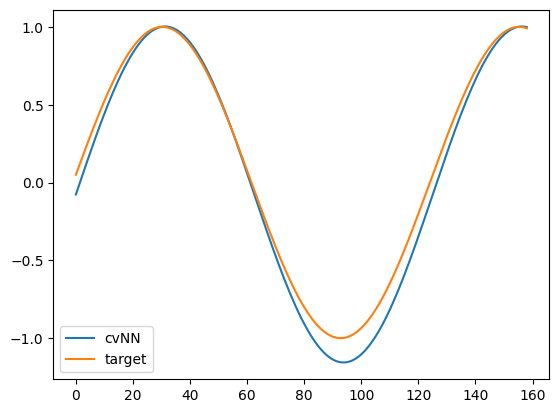

In [23]:
plt.plot(r_1.cpu().detach().numpy(),label="cvNN")
plt.plot(y_train.cpu().detach().numpy(),label="target")
plt.legend()

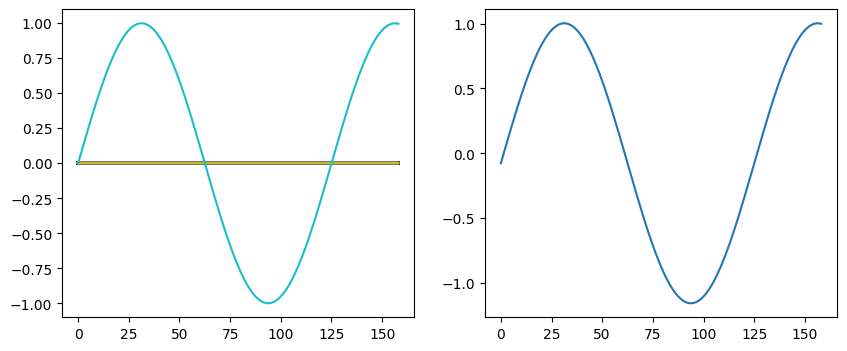

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(input_data.cpu().detach().numpy())

# ax1.plot(input_test.cpu().detach().numpy().T)


ax2.plot(r_1.cpu().detach().numpy())
# ax2.plot(x_r[:,-1,:].cpu().detach().numpy())


# r_1.shape

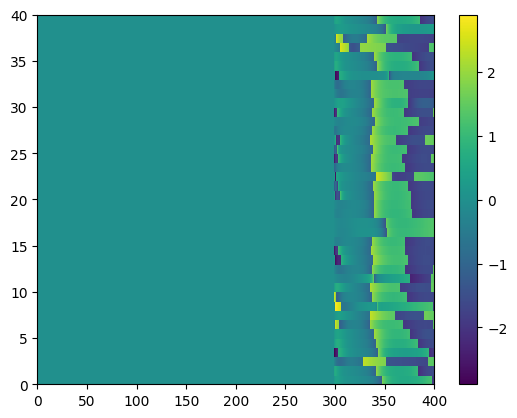

In [111]:
p=torch.arctan(x_i/x_r)

plt.pcolor((p[1,3600:,:]-p[40,3600:,:]).detach().cpu().numpy().T)
# plt.pcolor(p[10,:,:].detach().cpu().numpy().T)
plt.colorbar()

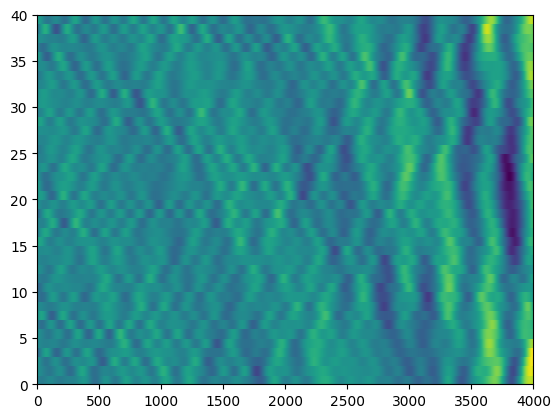

In [135]:
plt.pcolor(r_1[20,:,:].cpu().detach().numpy().T)


In [ ]:
# in_features = N
# out_features = 10
# layer = ComplexLinear(in_features, out_features)

In [ ]:
# Just saves last time step
# input_data=cv_NN_input(x_train,num)



# def cv_NN_state(inputD,num):
#     x_th = np.zeros((num, N), dtype=complex)
    
#     x_th_i = np.zeros((len(t), N), dtype=complex)
    
#     propagate = np.exp(1j * omega * dt) * expm(dt * K)
#     x_th_i[0, :] = x_0

#     for i in range(num):

#         for j in range(1, len(t)):
#             x_th_i[j, :] = propagate @ x_th_i[j - 1, :] + w_in.flatten() * inputD[i, j]
            
#         x_th[i,:]=x_th_i[-1,:]
            
#     return x_th



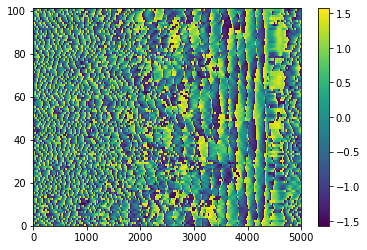

In [21]:
p=torch.arctan(x_th_imag/x_th_r)

plt.pcolor(p[2,:,:].detach().numpy().T)
plt.colorbar()

In [151]:
np.max(x_th.conj().T@x_th)

(1088.262095645753+1.7576382245414756e-15j)

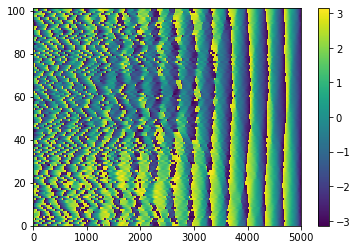

In [9]:

#phase plot
phase=np.angle(x_th[1,:,:])
plt.pcolor(phase.T)
plt.colorbar()

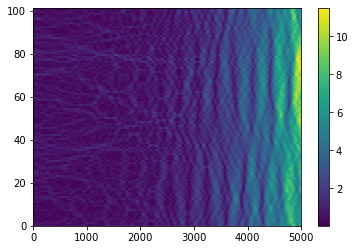

In [10]:
#amplitude
plt.pcolor(abs(x_th[1,:,:]).T)
plt.colorbar()

In [315]:
#Linear Regression

#D=x_th @ v

D=y[0:num,:]

D += 0.00001 * np.random.rand(*D.shape)
#D=D.T
D.shape

(150, 10)

In [316]:
def lin_reg(x_th,D,x,print_res=False):
    X = x_th #x_th[:,-1, :] #state of the the NN at final time step
    
    X_b=x #x[:,-1, :] #for prediction

    V=np.linalg.pinv(X.conj().T @ X)@X.conj().T@D
    
    pred=[]
    truth=[]
    
    for i in range(len(X_b)):
        res=X_b[i:i+1,:]@V
        
        pred.append(np.argmax(abs(res)))
        
        truth.append(np.argmax(D[i,:]))
        
        if print_res:

            print('prediction->',np.argmax(abs(res)),'Ground truth->',np.argmax(D[i,:]),np.max(abs(res)))
    

    
    
    return pred,truth

pred,truth=lin_reg(x_th,D,x_th,print_res=False)

In [317]:
#train accuracy


accuracy_score(pred,truth,normalize=True)



0.7

## Testing

In [318]:
num_test=100

X_t=x_test[:num_test,:]

D_t=tf.keras.utils.to_categorical(y_test[:num_test], num_classes = 10)
D_t += 0.001 * np.random.rand(*D_t.shape)
#D_t = D_t.T

In [319]:
test_data=cv_NN_input(X_t,num=num_test)
x_th_test=cv_NN_state(test_data,num=num_test)

In [320]:
# reg=lin_reg(x_th,D,x_th)

pred_test,truth_test=lin_reg(x_th,D,x_th_test,print_res=False)

accuracy_score(pred_test,truth_test,normalize=True)

0.11